# Analysis of Action-Rarity Criticality Scores

**Objective:** To load the criticality scores generated by `score_criticality_action.py`
and visualize them. This notebook helps verify that our action frequency analysis
is correctly identifying statistically rare and interesting expert behaviors.

In [5]:
# ## 1. Setup and Configuration

# +
import os
import sys
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

# Add project root to path
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

from src.utils.config import load_config
from src.data_processing.validate_parser_output import visualize_scenario

# Load project config and set plot style
config = load_config(config_path='../configs/main_config.yaml')
sns.set_theme(style="whitegrid")

print("Setup Complete.")

Configuration loaded successfully.
Setup Complete.


--- Starting Global Action-Rarity Score Analysis ---
Analyzing 8856 score files in parallel...


100%|██████████| 8856/8856 [00:03<00:00, 2586.88it/s]



--- Global Statistics for Timestep-Level Action Rarity ---
  Total Timesteps Analyzed: 797040
  Mean Score: 0.0104
  Std Dev Score: 0.0062
  99th Percentile: 0.0148


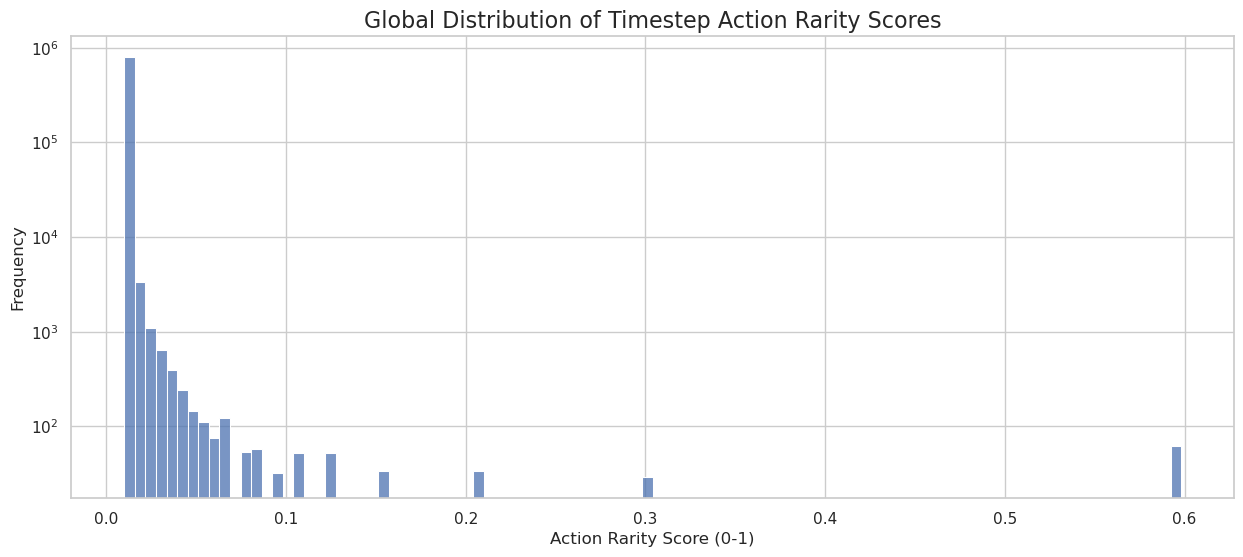


--- Top 10 Scenarios with Highest Average Action Rarity ---


,scenario_id,avg_rarity_score
2160,4a28daf3a8e82448,0.079720
7774,e28b76cfd0a00d11,0.051211
6832,c8b951a14a0ea191,0.050112
1017,2d129da061cb3f3c,0.031643
4965,9587642ec0735328,0.031235
1049,2e127453e3077034,0.030832
2728,598b295d74a9f7fa,0.028927
7933,e64dea98c172d8ab,0.027380
2051,477c971d3e2f0852,0.026904
3338,6a505b467dd4528a,0.026886


In [6]:
# ## 2. Global Distribution Analysis
# 
# This cell will process the ENTIRE validation set to compute the distribution of
# all timestep-level action rarity scores and to find the scenario with the
# highest average rarity.

# +
# --- Worker function for parallel processing ---
def analyze_rarity_file(file_path):
    """Loads a score file and calculates its average score."""
    try:
        data = np.load(file_path)
        scores = data['action_rarity']
        avg_score = np.mean(scores)
        scenario_id = os.path.splitext(os.path.basename(file_path))[0]
        # Return all scores for global histogram, and the average for ranking
        return (scores, (scenario_id, avg_score))
    except Exception:
        return None

# --- Main analysis logic ---
print("--- Starting Global Action-Rarity Score Analysis ---")
scores_dir = os.path.join(config['data']['criticality_scores_dir'], 'timestep_level', 'action_rarity', 'validation')
all_score_files = glob(os.path.join(scores_dir, '*.npz'))

if not all_score_files:
    raise FileNotFoundError(f"No action-rarity score files found in {scores_dir}.")
else:
    print(f"Analyzing {len(all_score_files)} score files in parallel...")
    
    with Pool(processes=cpu_count()) as pool:
        results = list(tqdm(pool.imap(analyze_rarity_file, all_score_files), total=len(all_score_files)))
    
    results = [res for res in results if res is not None]
    
    # --- Concatenate all scores for the global histogram ---
    all_scores_flat = np.concatenate([res[0] for res in results])
    
    # --- Create a DataFrame for ranking scenarios ---
    scenario_avg_scores = [res[1] for res in results]
    scores_df = pd.DataFrame(scenario_avg_scores, columns=['scenario_id', 'avg_rarity_score'])
    
    # --- Plot the Global Distribution ---
    print("\n--- Global Statistics for Timestep-Level Action Rarity ---")
    print(f"  Total Timesteps Analyzed: {len(all_scores_flat)}")
    print(f"  Mean Score: {np.mean(all_scores_flat):.4f}")
    print(f"  Std Dev Score: {np.std(all_scores_flat):.4f}")
    print(f"  99th Percentile: {np.percentile(all_scores_flat, 99):.4f}")

    plt.figure(figsize=(15, 6))
    sns.histplot(all_scores_flat, bins=100, kde=False)
    plt.title('Global Distribution of Timestep Action Rarity Scores', fontsize=16)
    plt.xlabel('Action Rarity Score (0-1)')
    plt.ylabel('Frequency')
    plt.yscale('log') # Log scale is essential to see the tail
    plt.show()

    # --- Identify Top "Rarest" Scenarios ---
    top_10_rare_scenarios = scores_df.sort_values(by='avg_rarity_score', ascending=False).head(10)
    print("\n--- Top 10 Scenarios with Highest Average Action Rarity ---")
    display(top_10_rare_scenarios)

--- Deep Dive Analysis for Top Scenario: e28b76cfd0a00d11 ---
Average Rarity Score: 0.0512


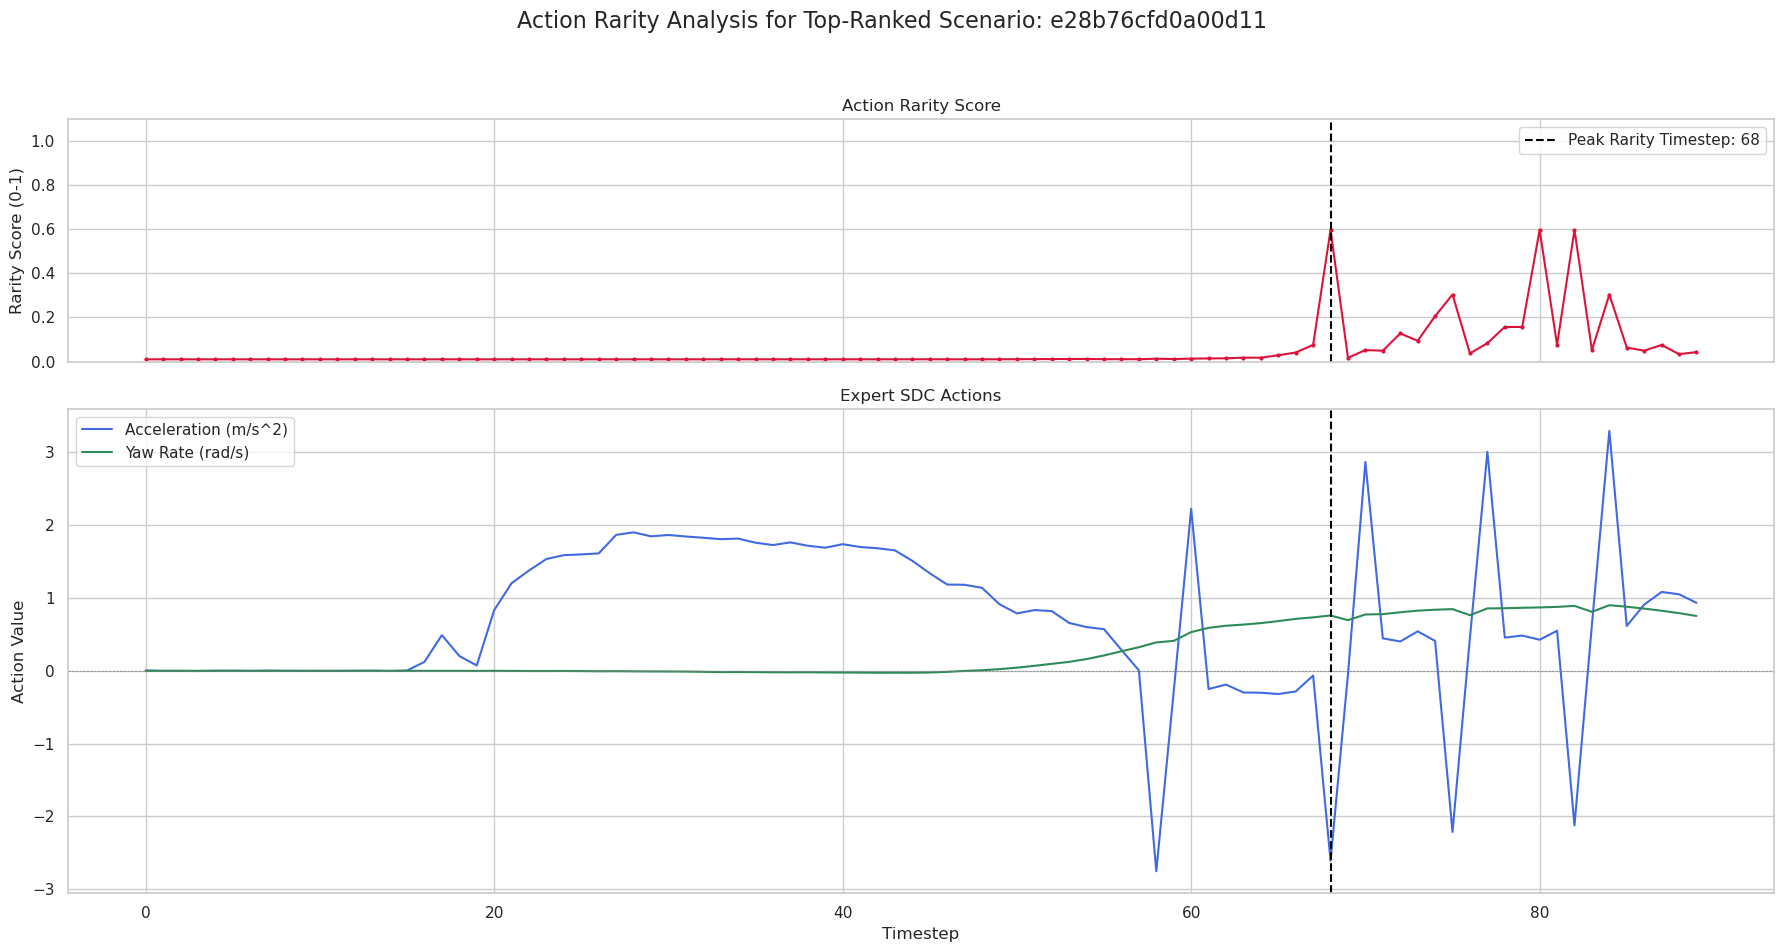

The moment of highest action rarity occurs at timestep 68.
Action at peak: Accel=-2.61, YawRate=0.76


In [11]:
# ## 3. Deep Dive into the Top-Ranked Scenario
# 
# Now we'll load the single scenario with the highest average action rarity and plot its score timeline against the actual actions to see why it was ranked so high.

# +
# Select the top scenario from the DataFrame we just created
top_scenario_id = top_10_rare_scenarios.iloc[1]['scenario_id']
top_scenario_avg_score = top_10_rare_scenarios.iloc[1]['avg_rarity_score']

print(f"--- Deep Dive Analysis for Top Scenario: {top_scenario_id} ---")
print(f"Average Rarity Score: {top_scenario_avg_score:.4f}")

# --- Load its score file and featurized action data ---
score_path = os.path.join(scores_dir, f"{top_scenario_id}.npz")
featurized_path = os.path.join(config['data']['featurized_dir'], 'validation', f"{top_scenario_id}.pt")

scores = np.load(score_path)['action_rarity']
actions = torch.load(featurized_path)['actions'].numpy()

# --- Plotting (same logic as the single-sample notebook) ---
fig, axes = plt.subplots(2, 1, figsize=(18, 10), sharex=True, 
                         gridspec_kw={'height_ratios': [1, 2]})
fig.suptitle(f'Action Rarity Analysis for Top-Ranked Scenario: {top_scenario_id}', fontsize=16)

timesteps = np.arange(len(scores))

# --- Plot 1: Rarity Score ---
axes[0].plot(timesteps, scores, marker='.', linestyle='-', markersize=4, color='crimson')
axes[0].set_title('Action Rarity Score')
axes[0].set_ylabel('Rarity Score (0-1)')
axes[0].set_ylim(0, 1.1)
axes[0].grid(True)

# Highlight the most critical timestep
most_critical_timestep = np.argmax(scores)
peak_score = np.max(scores)
axes[0].axvline(x=most_critical_timestep, color='black', linestyle='--', label=f'Peak Rarity Timestep: {most_critical_timestep}')
axes[0].legend()

# --- Plot 2: Actual Expert Actions ---
axes[1].plot(timesteps, actions[:, 0], label='Acceleration (m/s^2)', color='royalblue')
axes[1].plot(timesteps, actions[:, 1], label='Yaw Rate (rad/s)', color='seagreen')

axes[1].set_title('Expert SDC Actions')
axes[1].set_xlabel('Timestep')
axes[1].set_ylabel('Action Value')
axes[1].legend()
axes[1].grid(True)
axes[1].axhline(0, color='gray', linestyle='--', linewidth=0.5) # Add a zero line
axes[1].axvline(x=most_critical_timestep, color='black', linestyle='--')


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print(f"The moment of highest action rarity occurs at timestep {most_critical_timestep}.")
print(f"Action at peak: Accel={actions[most_critical_timestep, 0]:.2f}, YawRate={actions[most_critical_timestep, 1]:.2f}")


In [12]:
# ## 4. Generate Video for the Top Confusing Scenario
# 
# Finally, let's watch the video. What happens around the `Peak Disagreement Timestep`? Is it an unprotected left turn? A chaotic intersection? A pedestrian behaving strangely? This visual confirmation is key to trusting our model-based score.

# +
raw_data_path = os.path.join(
    config['data']['processed_npz_dir'], 
    'training', # Assuming it's from the training set
    f"{top_scenario_id}.npz"
)
if not os.path.exists(raw_data_path):
    # Check validation set if not in training
    raw_data_path = os.path.join(
        config['data']['processed_npz_dir'], 
        'validation',
        f"{top_scenario_id}.npz"
    )

print(f"\nGenerating scenario animation for: {top_scenario_id}...")
try:
    video_output_dir = 'outputs/action_validation_videos'
    visualize_scenario(raw_data_path, output_dir=video_output_dir)
    print(f"\n✅ Animation saved to '{video_output_dir}/{top_scenario_id}.mp4'")
except Exception as e:
    print(f"\n❌ An error occurred during animation: {e}")


Generating scenario animation for: e28b76cfd0a00d11...
Loading scenario from: /mnt/d/waymo_datasets/waymo_longtail_rl_data/processed_npz/validation/e28b76cfd0a00d11.npz
Creating animation for timestep 0 to 90...
Animation saved to: outputs/action_validation_videos/e28b76cfd0a00d11.mp4

✅ Animation saved to 'outputs/action_validation_videos/e28b76cfd0a00d11.mp4'
